In [56]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, RepeatedKFold, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif, VarianceThreshold
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_recall_curve
import seaborn as sb
from statistics import mean
import pickle

Data Analysis and Preprocessing

In [57]:
df = pd.read_csv(r'Static_dataset.csv')
df.head(10)

,timestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,Target Attack
0,56:19.8,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,1
1,07:23.9,27,10,0,10,11,2.767195,6,6,7,3.666667,2,192,14,1,1
2,23:15.1,26,9,0,10,10,2.742338,6,6,7,3.500000,2,192,13,1,0
3,04:51.9,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,1
4,12:44.0,15,9,0,11,0,2.929439,4,3,5,4.333333,local,local,15,1,1
5,16:29.5,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,1
6,26:58.3,23,3,0,20,0,3.568087,3,3,16,7.000000,pforzheim,pforzheim-bisons,20,1,0
7,57:29.2,24,7,0,10,8,2.054029,6,6,7,3.166667,4,224,11,1,1
8,27:59.6,14,3,0,12,0,2.514247,2,3,6,4.000000,face,reface,10,1,0
9,21:27.9,18,0,0,17,0,2.879113,1,2,14,8.500000,store,dellogliostore,15,0,0


In [58]:
df.replace((np.Inf, -np.Inf), np.nan)       #replacing infinity values with null to drop later

,timestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,Target Attack
0,56:19.8,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,1
1,07:23.9,27,10,0,10,11,2.767195,6,6,7,3.666667,2,192,14,1,1
2,23:15.1,26,9,0,10,10,2.742338,6,6,7,3.500000,2,192,13,1,0
3,04:51.9,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,1
4,12:44.0,15,9,0,11,0,2.929439,4,3,5,4.333333,local,local,15,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268069,33:51.5,18,3,0,16,0,2.338623,2,3,10,5.333333,alma,almaalomah,14,1,0
268070,36:02.5,27,10,0,10,11,2.767195,6,6,7,3.666667,2,192,14,1,0
268071,37:21.5,27,10,0,10,11,2.767195,6,6,7,3.666667,2,192,14,1,1
268072,24:25.1,16,0,0,14,0,3.249687,2,2,13,7.500000,radio,radio-vintage,14,0,0


In [59]:
df.info() #getting information about column values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268074 entries, 0 to 268073
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   timestamp         268074 non-null  object 
 1   FQDN_count        268074 non-null  int64  
 2   subdomain_length  268074 non-null  int64  
 3   upper             268074 non-null  int64  
 4   lower             268074 non-null  int64  
 5   numeric           268074 non-null  int64  
 6   entropy           268074 non-null  float64
 7   special           268074 non-null  int64  
 8   labels            268074 non-null  int64  
 9   labels_max        268074 non-null  int64  
 10  labels_average    268074 non-null  float64
 11  longest_word      268066 non-null  object 
 12  sld               268074 non-null  object 
 13  len               268074 non-null  int64  
 14  subdomain         268074 non-null  int64  
 15  Target Attack     268074 non-null  int64  
dtypes: float64(2), int64

In [60]:
df.dropna(inplace=True)     #dropping rows with null values

In [61]:
df.isnull().sum()           #checking for null values

timestamp           0
FQDN_count          0
subdomain_length    0
upper               0
lower               0
numeric             0
entropy             0
special             0
labels              0
labels_max          0
labels_average      0
longest_word        0
sld                 0
len                 0
subdomain           0
Target Attack       0
dtype: int64

Feature analysis

In [62]:
df['Target Attack'].value_counts()      #No imbalance so accuracy can be used as the metric

1    147179
0    120887
Name: Target Attack, dtype: int64

([<matplotlib.axis.XTick at 0x12400230430>,
 [Text(1, 0, 'Malignant'), Text(0, 0, 'Benign')])

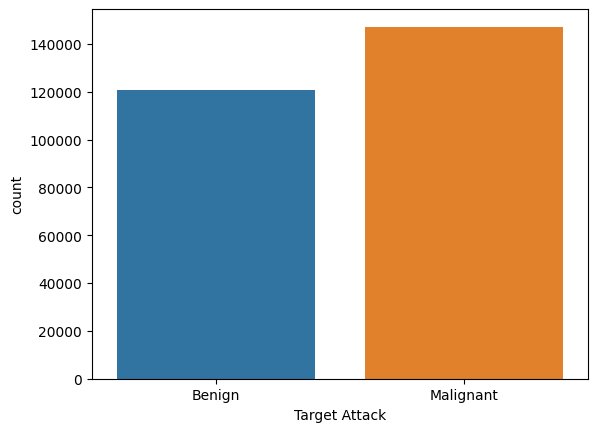

In [63]:
sb.countplot(x=df['Target Attack'])
plt.xticks(ticks=(1,0), labels=['Malignant', 'Benign'])

Attempting to sort the data using timestamp

In [64]:
df['timestamp'].describe()

count      268066
unique      35924
top       49:26.7
freq           46
Name: timestamp, dtype: object

In [65]:
df.sort_values(by='timestamp')      #timestamp does not contain enough details to uniquely sort rows

,timestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,Target Attack
214344,00:00.0,25,8,0,10,9,2.556642,6,6,7,3.333333,2,192,12,1,0
207865,00:00.0,24,7,0,10,8,2.054029,6,6,7,3.166667,4,224,11,1,1
190770,00:00.0,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,1
46599,00:00.0,5,0,0,4,0,0.389975,1,2,2,2.000000,gg,gg,3,0,0
107763,00:00.0,24,7,0,10,8,2.054029,6,6,7,3.166667,4,224,11,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138807,59:59.9,25,8,0,10,9,2.556642,6,6,7,3.333333,2,192,12,1,1
29929,59:59.9,18,3,0,16,0,3.012446,2,3,11,5.333333,chilevisi,chilevision,15,1,0
127657,59:59.9,25,8,0,10,9,2.556642,6,6,7,3.333333,2,192,12,1,1
4421,59:59.9,5,0,0,4,0,0.389975,1,2,2,2.000000,gg,gg,3,0,0


In [66]:
df.drop('timestamp', axis=1, inplace=True)

In [67]:
df.head()

,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,Target Attack
0,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,1
1,27,10,0,10,11,2.767195,6,6,7,3.666667,2,192,14,1,1
2,26,9,0,10,10,2.742338,6,6,7,3.500000,2,192,13,1,0
3,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,1
4,15,9,0,11,0,2.929439,4,3,5,4.333333,local,local,15,1,1


In [68]:
df['longest_word'].value_counts()

2          109981
4           70188
N            4498
C            2969
9            1906
            ...  
yaa             1
queue           1
kit             1
airdrop         1
mal             1
Name: longest_word, Length: 6224, dtype: int64

In [69]:
''' 
vect = CountVectorizer()
wordarray = df['longest_word'].to_numpy()
wordarray = wordarray.flatten()
print(wordarray)
countwords = vect.fit_transform(wordarray)

print(countwords.toarray())
'''

" \nvect = CountVectorizer()\nwordarray = df['longest_word'].to_numpy()\nwordarray = wordarray.flatten()\nprint(wordarray)\ncountwords = vect.fit_transform(wordarray)\n\nprint(countwords.toarray())\n"

In [70]:
df['longest_word'] = df['longest_word'].str.len()       #Converted the feature value to the length of the value (string to int)
df['sld'] = df['sld'].apply(hash)                       #Converted the feature to hash values for consistent length ints

In [71]:
df['longest_word'].value_counts()

1     193739
4      15865
5      14069
3      13861
6       8721
2       7790
7       6494
8       3548
9       2296
10      1033
11       427
12       117
13        71
14        24
15         6
16         5
Name: longest_word, dtype: int64

In [72]:
df['sld'].value_counts()

 1727663735972361720    109517
 5748482361483160807     70188
-5355199545569129029      4498
 5924505273382905201      1961
-2529372380826707727      1906
                         ...  
 950895921272603621          1
-8392473437386694705         1
 5956386166803132652         1
 6070798207529688335         1
 5998107663435311719         1
Name: sld, Length: 11110, dtype: int64

In [73]:
df.dtypes

FQDN_count            int64
subdomain_length      int64
upper                 int64
lower                 int64
numeric               int64
entropy             float64
special               int64
labels                int64
labels_max            int64
labels_average      float64
longest_word          int64
sld                   int64
len                   int64
subdomain             int64
Target Attack         int64
dtype: object

In [74]:
y = df['Target Attack']                             #Getting X input and y target
X = df.drop(['Target Attack'], axis=1)

In [75]:
X.isnull().sum()

FQDN_count          0
subdomain_length    0
upper               0
lower               0
numeric             0
entropy             0
special             0
labels              0
labels_max          0
labels_average      0
longest_word        0
sld                 0
len                 0
subdomain           0
dtype: int64

In [76]:
y.isnull().sum()

0

In [77]:
features = mutual_info_classif(X, y, random_state=42)                       #Feature analysis using mutual information
best_features = []
scores = []
for score, f_name in sorted(zip(features, X.columns), reverse=True):
    print(f_name, score)
    best_features.append(f_name)
    scores.append(score)

sld 0.29597528155789976
labels 0.2922383930238077
special 0.28714101952421145
entropy 0.26878279574885333
longest_word 0.2678011946112846
FQDN_count 0.2614878059703696
lower 0.25420633552796357
labels_average 0.24602755384191677
labels_max 0.23513076977640268
subdomain_length 0.2304347205288162
numeric 0.22284222043920776
len 0.1613102134026292
subdomain 0.15906287370700856
upper 0.003406294270859478


Text(0.5, 1.0, 'Mutual Information Score')

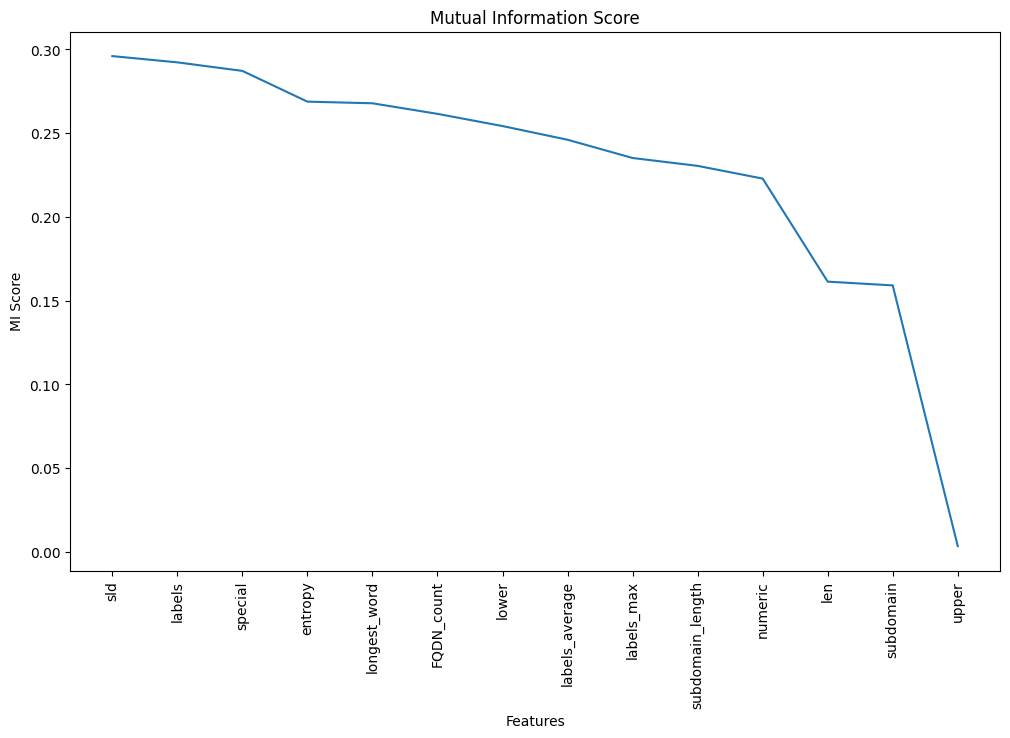

In [78]:
plt.figure(figsize=(12,7))
plt.xlabel("Features")
plt.ylabel("MI Score")
plt.plot(best_features, scores)
plt.xticks(rotation=90)
plt.title("Mutual Information Score")

In [79]:
x_features = []                                                 #Features after filtering
for f, sc in (zip(best_features, scores)):
    if(sc > 0.24):
        x_features.append(f)
#X = X[x_features]
print(X[x_features].columns)

Index(['sld', 'labels', 'special', 'entropy', 'longest_word', 'FQDN_count',
       'lower', 'labels_average'],
      dtype='object')


In [80]:
df1 = X.copy()
df1['Target Attack'] = y

<AxesSubplot: >

<Figure size 640x480 with 0 Axes>

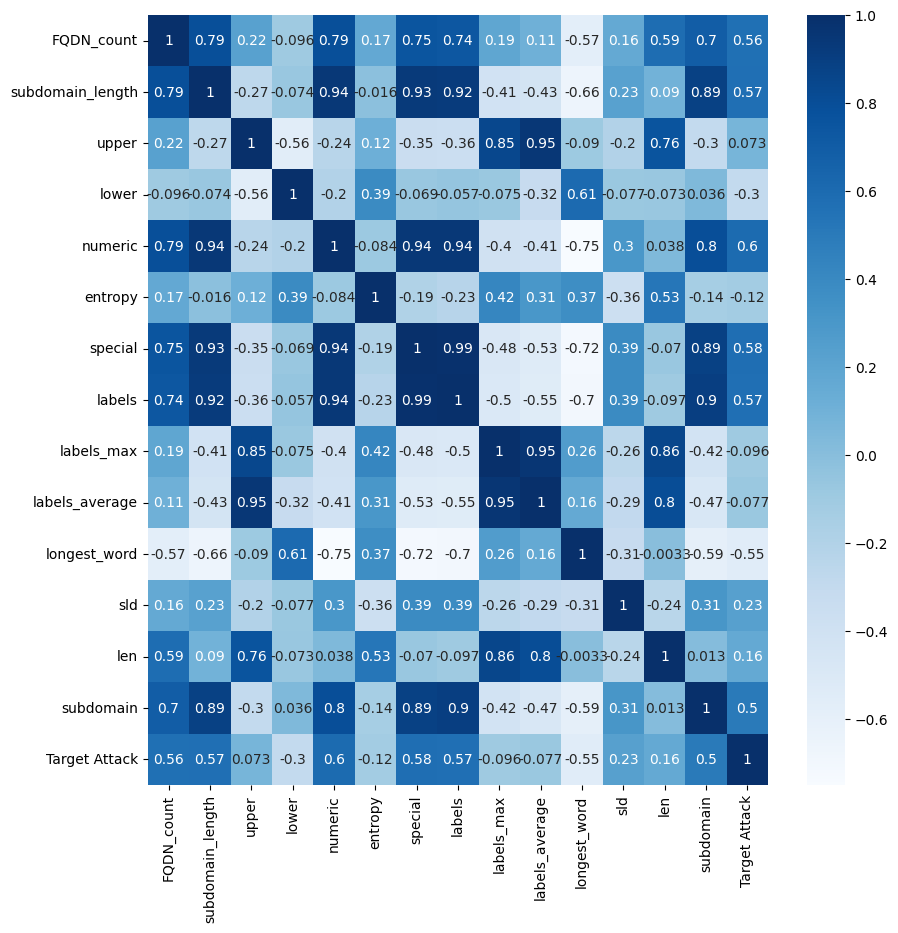

In [81]:
plt.figure()                                                                #correlation heatmap
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
corr = df1.corr()
sb.heatmap(corr, cmap = 'Blues', annot=True, ax=ax)

Model Selection, Hyperparameter Tuning, and Evaluation

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [83]:
clf1 = RandomForestClassifier(random_state=42)
clf2 = GradientBoostingClassifier(random_state=42)

In [84]:
scoredf = pd.DataFrame(data = {'Model': [], 'Score': []})   #dataframe to store randomsearch scores
scoredf

,Model,Score


In [85]:
param1 = {                                      #parameters for 2 models
'classifier__n_estimators': [10, 50, 100],
'classifier__max_depth': [5, 10, 20]
#'classifier__min_samples_split': [2,5,10]
}
param2 = {
'classifier__n_estimators': [10, 50, 100],
'classifier__learning_rate': [0.01, 0.05, 0.1],
'classifier__max_depth': [5, 10, 20]
#'classifier__min_samples_split': [2,5,10] 
}

In [86]:
pipeline = Pipeline([('selector', SelectKBest(mutual_info_classif, k=6)),('scaler', StandardScaler()), ('classifier', clf1)])   #Creating pipelines for 2 random searches
pipeline2 = Pipeline([('selector', SelectKBest(f_classif, k=6)),('scaler', StandardScaler()), ('classifier', clf1)])

In [87]:
#Running randomizedsearch for the models and params to get the best params efficiently
grid = RandomizedSearchCV(pipeline, param1, cv=3, n_jobs=-1, scoring='f1', verbose=1).fit(X_train, y_train)
scoredf.loc[-1] = ['RF_MI', grid.best_score_]
scoredf.index = scoredf.index+1
scoredf.sort_index

d:\Users\Gautam\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 9 candidates, totalling 27 fits


<bound method DataFrame.sort_index of    Model     Score
0  RF_MI  0.863266>

In [88]:
grid2 = RandomizedSearchCV(pipeline2, param1, cv = 3, n_jobs=-1, scoring='f1', verbose=1).fit(X_train, y_train) #Second search using ANOVA selection and RandomForests
scoredf.loc[-1] = ["RF_ANOVA-F", grid2.best_score_]
scoredf.index = scoredf.index+1
scoredf.sort_index

d:\Users\Gautam\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 9 candidates, totalling 27 fits


<bound method DataFrame.sort_index of         Model     Score
1       RF_MI  0.863266
0  RF_ANOVA-F  0.862904>

In [89]:
print(df.columns[grid.best_estimator_.named_steps['selector'].get_support(indices=True)])       #outputting features selected
print(df.columns[grid2.best_estimator_.named_steps['selector'].get_support(indices=True)])

Index(['FQDN_count', 'entropy', 'special', 'labels', 'longest_word', 'sld'], dtype='object')
Index(['FQDN_count', 'subdomain_length', 'numeric', 'special', 'labels',
       'longest_word'],
      dtype='object')


In [90]:
pipeline3 = Pipeline([('selector', SelectKBest(mutual_info_classif, k=6)),('scaler', StandardScaler()), ('classifier', clf2)])  #Pipelines for gradient boosting
pipeline4 = Pipeline([('selector', SelectKBest(f_classif, k=6)),('scaler', StandardScaler()), ('classifier', clf2)])

In [91]:
grid3=RandomizedSearchCV(pipeline3, param2, cv = 3, n_jobs=-1, scoring='f1', verbose=1).fit(X_train, y_train)   #search using gradient boosting and mutual information
scoredf.loc[-1] = ["GB_MI", grid3.best_score_]
scoredf.index = scoredf.index+1
scoredf.sort_index

Fitting 3 folds for each of 10 candidates, totalling 30 fits


<bound method DataFrame.sort_index of         Model     Score
2       RF_MI  0.863266
1  RF_ANOVA-F  0.862904
0       GB_MI  0.863273>

In [92]:
grid4=RandomizedSearchCV(pipeline4, param2, cv = 3, n_jobs=-1, scoring='f1', verbose=1).fit(X_train, y_train)
scoredf.loc[-1] = ["GB_ANOVA-F", grid4.best_score_]
scoredf.index = scoredf.index+1
scoredf.sort_index(ascending=True)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


,Model,Score
0,GB_ANOVA-F,0.862886
1,GB_MI,0.863273
2,RF_ANOVA-F,0.862904
3,RF_MI,0.863266


In [93]:
print(df.columns[grid3.best_estimator_.named_steps['selector'].get_support(indices=True)])
print(df.columns[grid4.best_estimator_.named_steps['selector'].get_support(indices=True)])

Index(['FQDN_count', 'entropy', 'special', 'labels', 'longest_word', 'sld'], dtype='object')
Index(['FQDN_count', 'subdomain_length', 'numeric', 'special', 'labels',
       'longest_word'],
      dtype='object')


<Figure size 1500x500 with 0 Axes>

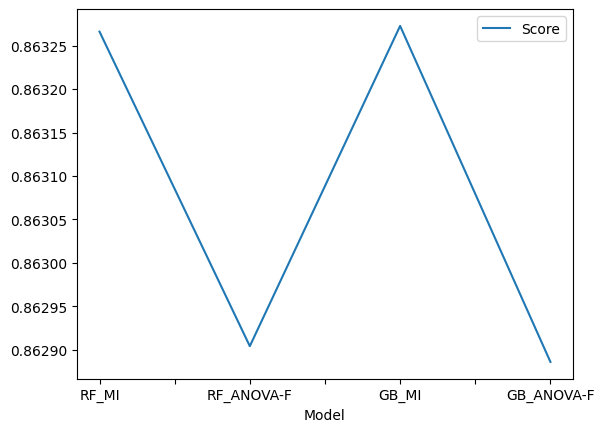

In [94]:
plt.figure(figsize=(15,5))                              #Comparing results using 2 models and 2 feature selection techniques
scoredf.plot(kind="line", x='Model', y = 'Score')
plt.show()

Evaluation

In [95]:
grids = [grid, grid2, grid3, grid4]             #Getting the best estimator from the searches
finalgrid = grids[scoredf['Score'].idxmax()]
print(finalgrid.best_estimator_['classifier'])

RandomForestClassifier(max_depth=20, n_estimators=50, random_state=42)


In [96]:
mask = finalgrid.best_estimator_.named_steps['selector'].get_support()                          #Dropping features using the feature selection method
print(df.columns[finalgrid.best_estimator_.named_steps['selector'].get_support(indices=True)])
print(mask)
X_train =X_train.loc[:, mask]
X_test = X_test.loc[:, mask]
#X_train_scaled[X_train_scaled.columns[varthresh.get_support(indices=True)]]

Index(['FQDN_count', 'subdomain_length', 'numeric', 'special', 'labels',
       'longest_word'],
      dtype='object')
[ True  True False False  True False  True  True False False  True False
 False False]


In [97]:
scaler = StandardScaler()                       #Scaling train and test set
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [98]:
model2 = finalgrid.best_estimator_['classifier']                       #Fitting the model used by the best search result
model2.fit(X_train_scaled, y_train)
Y_pred = model2.predict(X_test_scaled)
print("F1 Score: ", classification_report(Y_pred, y_test))          #Evaluation results


F1 Score:                precision    recall  f1-score   support

           0       0.61      1.00      0.76     18597
           1       1.00      0.76      0.86     48420

    accuracy                           0.83     67017
   macro avg       0.81      0.88      0.81     67017
weighted avg       0.89      0.83      0.83     67017



<AxesSubplot: >

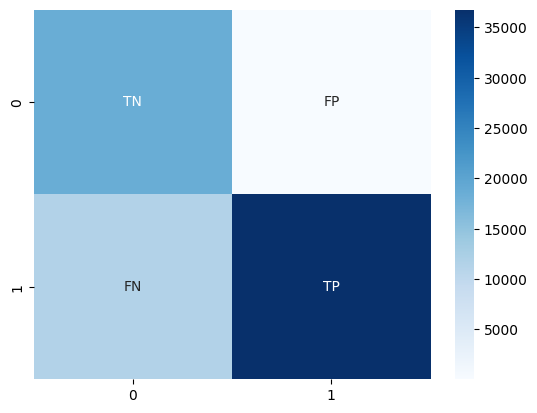

In [99]:
plt.figure()                                                            #Confusion matrix for the predicted and true values
labels = ['TN','FP','FN','TP']
labels = np.asarray(labels).reshape(2,2)
sb.heatmap(confusion_matrix(Y_pred, y_test), annot=labels, fmt='', cmap='Blues')

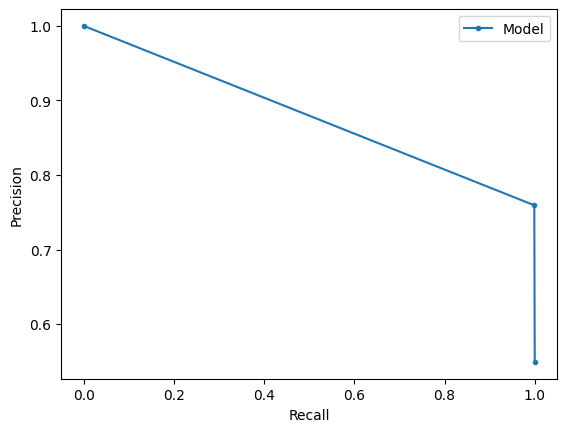

In [100]:
precision, recall, _ = precision_recall_curve(y_test, Y_pred)
plt.plot(recall, precision, marker='.', label='Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

Final Static Model Development

In [101]:
print(finalgrid)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('selector', SelectKBest(k=6)),
                                             ('scaler', StandardScaler()),
                                             ('classifier',
                                              RandomForestClassifier(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'classifier__max_depth': [5, 10, 20],
                                        'classifier__n_estimators': [10, 50,
                                                                     100]},
                   scoring='f1', verbose=1)


In [102]:
scaler = StandardScaler()       #Creating and fitting final model
X = X.loc[:, mask]
X = scaler.fit_transform(X)
model=finalgrid.best_estimator_['classifier']
model.set_params(warm_start=True)
#model = GradientBoostingClassifier(n_estimators=100, max_depth=20, learning_rate=0.01, warm_start=True, random_state=42)
model.fit(X, y)

GradientBoostingClassifier(learning_rate=0.01, max_depth=20, random_state=42,
                           warm_start=True)

Saving Files for dynamic implementation

In [103]:
pkl_filename = "static_model.pkl"           
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

In [104]:
pkl_filename = "scaler.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(scaler, file)

In [105]:
pkl_filename = "mask.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(mask, file)